In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import scipy.stats as stats

In [53]:
# df_MMRT = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRT.csv')

df_MMRTNE = pd.read_csv(
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv"
)
df_OECD = pd.read_csv("../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv")

In [54]:
# select which df to use

df = df_MMRTNE
indicator_y = "SH.STA.MMRT.NE"

# df = df_MMRT
# indicator_y = 'SH.STA.MMRT'

# df = df_OECD
# indicator_y = 'MATIMATM'

# Perform hyperparameter tuning?
perform_hp_tuning = False

In [55]:
# First need to encode the country

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep=True)
data_encoded["Country"] = country_encoder.fit_transform(data_encoded["Country"])

### Random Forest

In [56]:
# pull out Maternal Mortality as the predictor variable
X = data_encoded.drop(columns=indicator_y)
y = data_encoded[indicator_y]

### Hyperparameter Tuning

In [57]:
if perform_hp_tuning:
    # Create a Random Forest Regressor
    rf_regressor = RandomForestRegressor(random_state=42)

    # Define a grid of hyperparameters to search
    parameter_grid = {
        "n_estimators": [10, 20, 40],
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 6, 10, 20],
        "bootstrap": [True, False],
    }

    # Define distributions of hyperparameters to search
    parameter_dist = {
        "n_estimators": stats.randint(10, 40),
        "max_depth": stats.randint(10, 50),
        "min_samples_split": stats.randint(2, 20),
        "min_samples_leaf": stats.randint(1, 20),
        "bootstrap": [True],
    }

    # Create a RandomSearchCV object with cross-validation
    # grid_search = GridSearchCV(estimator = rf_regressor, param_grid = parameter_grid, cv=5)

    # 60 is number of iterations suggested by ML research
    grid_search = RandomizedSearchCV(
        estimator=rf_regressor,
        param_distributions=parameter_dist,
        cv=5,
        n_iter=60,
        random_state=42,
    )

    # Fit the grid search to the data
    grid_search.fit(X, y)

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_

    # Get the best Random Forest Regressor model
    best_rf_regressor = grid_search.best_estimator_

    best_n_estimators = best_hyperparameters["n_estimators"]
    best_max_depth = best_hyperparameters["max_depth"]
    best_min_samples_split = best_hyperparameters["min_samples_split"]
    best_min_samples_leaf = best_hyperparameters["min_samples_leaf"]
    best_bootstrap = best_hyperparameters["bootstrap"]

    print(f"Best n_estimators: {best_n_estimators}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best min_samples_split: {best_min_samples_split}")
    print(f"Best min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best bootstrap: {best_bootstrap}")

else:
    # Take the values found from the previous hyperparameter tuning step

    if indicator_y == "MATIMATM":  # OECD data is being modeled
        best_n_estimators = 11
        best_max_depth = 25
        best_min_samples_split = 18
        best_min_samples_leaf = 16
        best_bootstrap = True

    elif indicator_y == "SH.STA.MMRT.NE":  # World Bank Data is being modeled
        best_n_estimators = 17
        best_max_depth = 48
        best_min_samples_split = 12
        best_min_samples_leaf = 15
        best_bootstrap = True

Best n_estimators: 17
Best max_depth: 48
Best min_samples_split: 12
Best min_samples_leaf: 15
Best bootstrap: True


### 5 Fold Cross Validation 

In [58]:
# Create a list to store the mean squared errors (MSE) for each fold
mse_scores = []
r2_scores = []

# initialize the best r2 score
best_r2_score = -100000
best_model = None


# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    bootstrap=best_bootstrap,
    random_state=42,
)

# Create a KFold cross-validator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_regressor.predict(X_test)

    # Calculate the mean squared error (MSE) for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Keep the best model based on r2 score
    if r2 > best_r2_score:
        # Save the best r2 score and best model
        best_r2_score = r2
        best_model = rf_regressor
        # Save the respective train test split
        X_train_best = X_train
        X_test_best = X_test
        y_train_best = y_train
        y_test_best = y_test

# Calculate the mean and standard deviation of the MSE scores and r2 scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Best R-squared (R2): {best_r2_score}")
print(f"Mean R-squared (R2): {mean_r2}")
print(f"Standard Deviation of R-squared (R2): {std_r2}")
print(f"Average Mean Squared Error (MSE): {mean_mse}")
print(f"Standard Deviation of Mean Squared Error (MSE): {std_mse}")

Best R-squared (R2): 0.8304426469259775
Mean R-squared (R2): 0.7788100842722308
Standard Deviation of R-squared (R2): 0.04156210164786255
Average Mean Squared Error (MSE): 69.96262471360352
Standard Deviation of Mean Squared Error (MSE): 28.044268450335323


In [59]:
# re-establishing the train test split from the best model
X_train = X_train_best
X_test = X_test_best
y_train = y_train_best
y_test = y_test_best
y_pred = best_model.predict(X_test)

### A Look at Feature Importance

In [60]:
# Import utility functions
import sys

sys.path.append("../utility_functions")
from ind_utility_functions import get_ind_name, get_ind_info

In [61]:
feature_importance = best_model.feature_importances_

Index(['SH.DYN.STLB', 'SP.ADO.TFRT', 'SH.DYN.MORT.MA', 'SH.STA.OB18.MA.ZS',
       'SH.XPD.GHED.PP.CD', 'SH.XPD.GHED.PC.CD', 'SH.DYN.1014',
       'SH.SGR.IRSK.ZS', 'SH.DYN.NMRT', 'GB.XPD.RSDV.GD.ZS'],
      dtype='object')


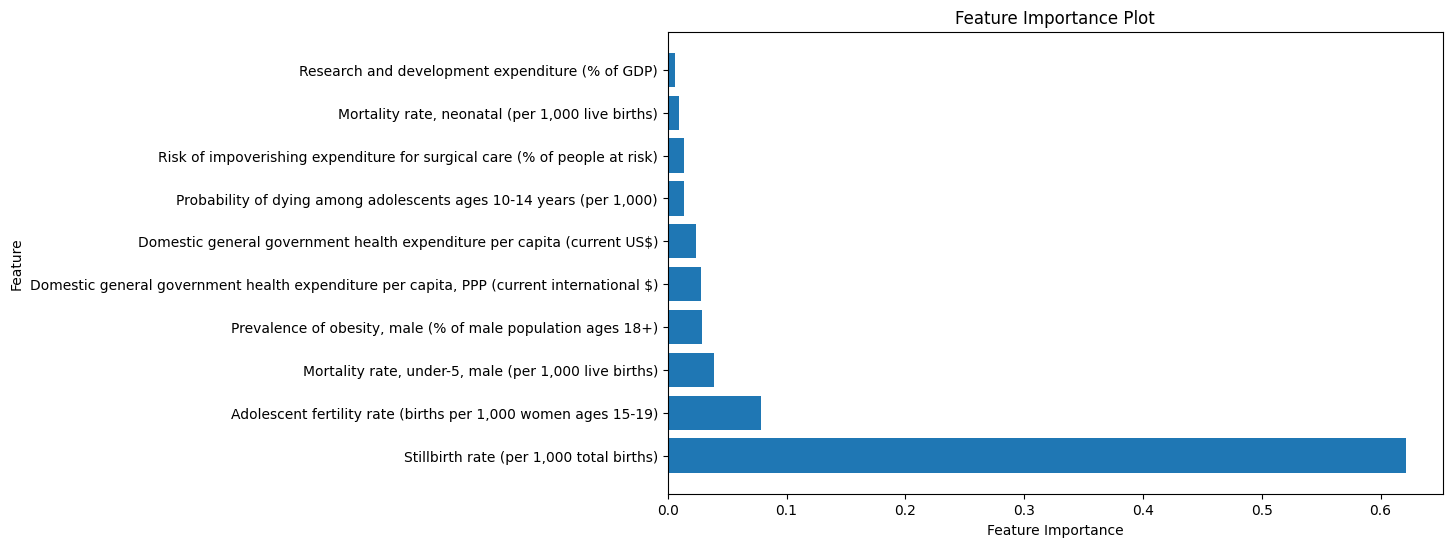

In [62]:
# Sort features by importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1][
    :10
]  # pull only the top 10 features
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importance[sorted_indices]

print(sorted_feature_names)
sorted_feature_names = [
    get_ind_name(i) for i in sorted_feature_names
]  # Map feature codes to names

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Plot")
plt.show()